In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
from tqdm.auto import tqdm

In [3]:
import mctspy as mct

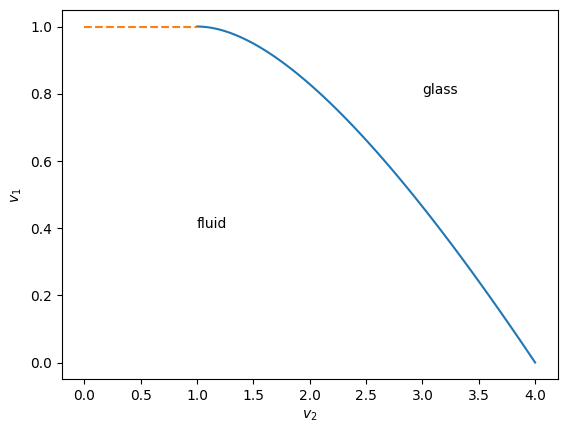

In [4]:
lvals = np.linspace(0.5,1,101)
plt.plot(1/lvals**2, (2*lvals-1)/lvals**2)
lvals = np.linspace(0,1,11)
plt.plot(lvals,np.ones_like(lvals),linestyle='dashed')
ax = plt.gca()
ax.text(3,0.8,'glass')
ax.text(1,0.4,'fluid')
plt.xlabel(r'$v_2$')
plt.ylabel(r'$v_1$')
plt.show()

In [5]:
model = mct.f12model (v1=2*(np.sqrt(2)-1) - 1e-3/(np.sqrt(2)-1), v2=2)

In [6]:
phi = mct.correlator (model=model, store=True)

In [7]:
correlators = mct.CorrelatorStack([phi])

In [8]:
model_s = mct.sjoegren_model(vs=30, base_model=model)
phi_s = mct.correlator (model=model_s, base=phi, store=True)
correlators.append(phi_s)

In [9]:
correlators.solve_all()

True

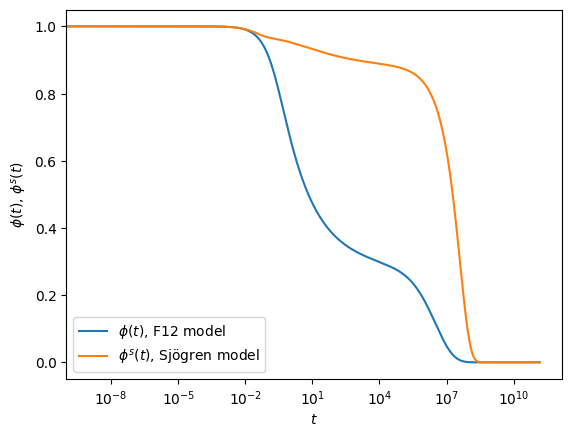

In [10]:
plt.plot(phi.t, phi.phi, label=r'$\phi(t)$, F12 model')
plt.plot(phi_s.t, phi_s.phi, label=r'$\phi^s(t)$, Sjögren model')
plt.xscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$\phi(t)$, $\phi^s(t)$')
plt.legend()
plt.show()

In [11]:
def FT (f, t, w):
    t_, w_ = np.meshgrid (t, w)
    f_ = np.tile(f, w.shape[0]).reshape(w.shape[0],-1)
    fwre = mct.util.filon_cos_transform(f_, t_, w_)
    fwim = mct.util.filon_sin_transform(f_, t_, w_)
    return fwre + 1j*fwim

In [12]:
w = 10**np.linspace(-10,2,200)
phi_w = FT (phi.phi[:,0], phi.t, w)
phi_s_w = FT (phi_s.phi[:,0], phi_s.t, w)

In [13]:
chi = 1j*w*phi_w
chi_s = 1j*w*phi_s_w

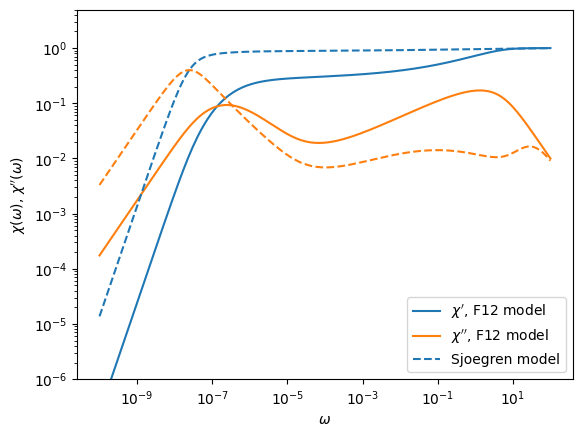

In [14]:
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.plot(w, -chi.real, label=r"$\chi'$, F12 model", color=next(colors))
plt.plot(w, chi.imag, label=r"$\chi''$, F12 model", color=next(colors))
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.plot(w, -chi_s.real, label=r"Sjoegren model", color=next(colors), linestyle='dashed')
plt.plot(w, chi_s.imag, color=next(colors), linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega$')
plt.ylabel(r"$\chi(\omega)$, $\chi''(\omega)$")
plt.ylim(1e-6,5)
plt.legend()
plt.show()

In [15]:
m_w = FT (phi.m[:,0], phi.t, w)

In [16]:
phi_from_m = (m_w+1)/(-1j*w*(1+m_w)+1)

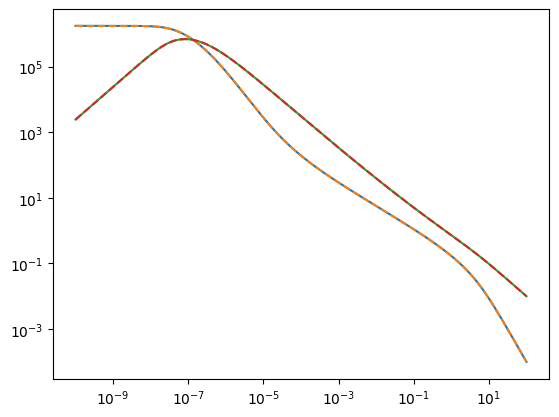

In [17]:
plt.plot(w, phi_w.real)
plt.plot(w, phi_from_m.real, linestyle='dashed')
plt.plot(w, phi_w.imag)
plt.plot(w, phi_from_m.imag, linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
m_from_phi = -1+phi_w/(1+1j*w*phi_w)

In [19]:
df = np.gradient(phi.phi[:,0], phi.t)
dphi_w = FT(df, phi.t, w)
m_from_phi_dphi = -1 - phi_w/dphi_w

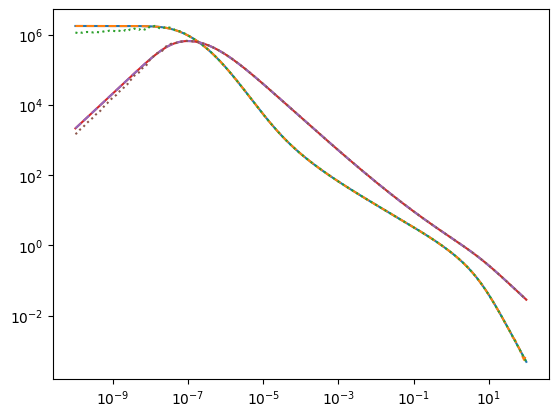

In [20]:
plt.plot(w, m_w.real)
plt.plot(w, m_from_phi.real, linestyle='dashed')
plt.plot(w, m_from_phi_dphi.real, linestyle='dotted')
plt.plot(w, m_w.imag)
plt.plot(w, m_from_phi.imag, linestyle='dashed')
plt.plot(w, m_from_phi_dphi.imag, linestyle='dotted')
plt.xscale('log')
plt.yscale('log')
plt.show()

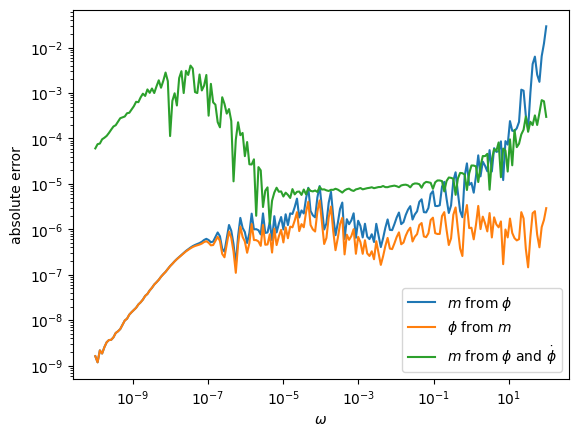

In [21]:
plt.plot(w,np.abs(m_w-m_from_phi)*w, label=r'$m$ from $\phi$')
plt.plot(w,np.abs(phi_w-phi_from_m)*w, label=r'$\phi$ from $m$')
plt.plot(w,np.abs(m_w-m_from_phi_dphi)*w, label=r'$m$ from $\phi$ and $\dot\phi$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega$')
plt.ylabel('absolute error')
plt.legend()
plt.show()

In [22]:
def f(lval):
    v1c, v2c = (2*lval-1)/lval**2, 1/lval**2
    return 1 - (v1c+v2c)/(2*v2c) + np.sqrt((v1c+v2c)**2/(4*v2c**2) - 1/v2c)
def fc(lval):
    return 1-lval

In [23]:
lvals=np.linspace(0.5,0.9,5)

In [24]:
lphi = {}
for lval in tqdm(lvals):
    v1, v2 = (2*lval-1)/lval**2 - 1e-5, 1/lval**2
    lphi[lval] = mct.correlator(model = mct.f12model (v1=v1, v2=v2), store = True)
    lphi[lval].solve_all()

  0%|          | 0/5 [00:00<?, ?it/s]

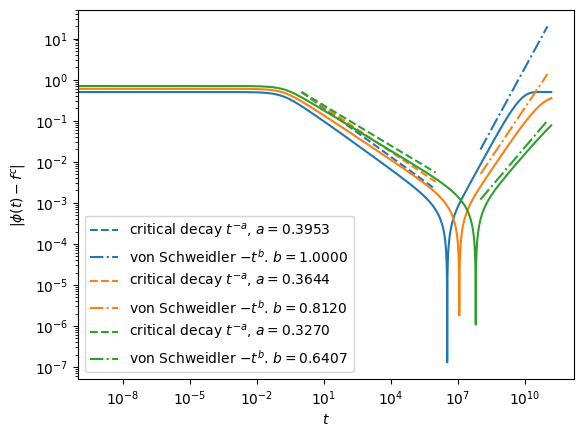

In [25]:
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for lval in lvals[:-2]:
    c = next(colors)
    phimod = np.abs(lphi[lval].phi - fc(lval))
    plt.plot(lphi[lval].t,phimod, color=c)
    a, b = mct.util.exponents(lval)
    tr = 10**np.linspace(0,6,10)
    plt.plot(tr, 0.5*tr**-a,linestyle='dashed',color=c,label=r'critical decay $t^{{-a}}$, $a={:.4f}$'.format(a))
    tr = 10**np.linspace(8,11,10)
    plt.plot(tr, phimod[-1200,0]*(tr/tr[0])**b,linestyle='dashdot',color=c,label=r'von Schweidler $-t^b$. $b={:.4f}$'.format(b))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$|\phi(t)-f^c|$')
plt.legend()
plt.show()

In [26]:
nrange=np.arange(1,5)
f1model = {}
for n in nrange:
    f1model[-n] = mct.f12model(1.0-10.**-n, 0.0)
    f1model[n] = mct.f12model(1.0+10.**-n, 0.0)

In [27]:
correlators = mct.CorrelatorStack()
for n in f1model:
    correlators.append(mct.correlator (model=f1model[n], blocks=50, maxiter=1000000, blocksize=512, accuracy=1e-12, store=True))
correlators.solve_all()

True

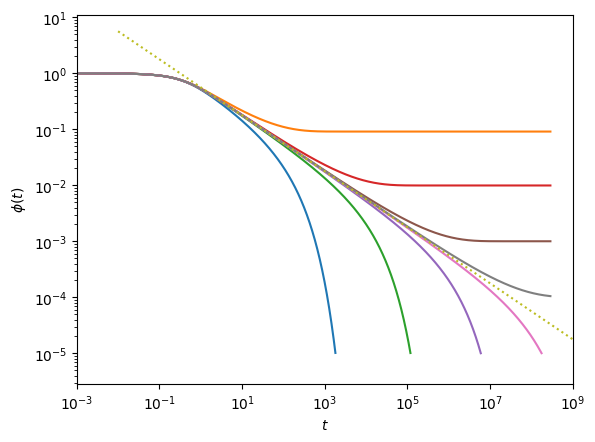

In [28]:
for phi in correlators:
    mask = phi.phi[:,0]>=1e-5
    plt.plot(phi.t[mask], phi.phi[:,0][mask])
trange = 10**np.linspace(-2,10,10)
plt.plot(trange, (trange/0.314)**-0.5, linestyle='dotted')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$\phi(t)$')
plt.xlim(1e-3,1e9)
plt.show()

In [29]:
ftcorrelators = [FT(phi.phi[:,0]-phi.phi[-1,0], phi.t, w) for phi in correlators]

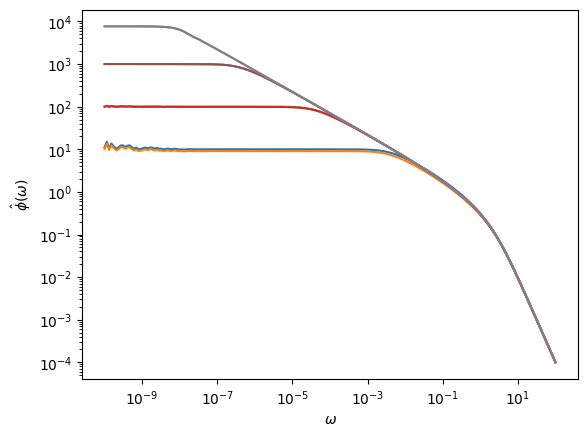

In [30]:
for phi_w in ftcorrelators:
    plt.plot(w, phi_w.real)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\hat\phi(\omega)$')
plt.show()

In [31]:
def f1analytical(s, v1):
    return (v1-s-1)/(2*s*v1) + np.sqrt(((v1-s-1)/(2*s*v1))**2+1/(v1*s))

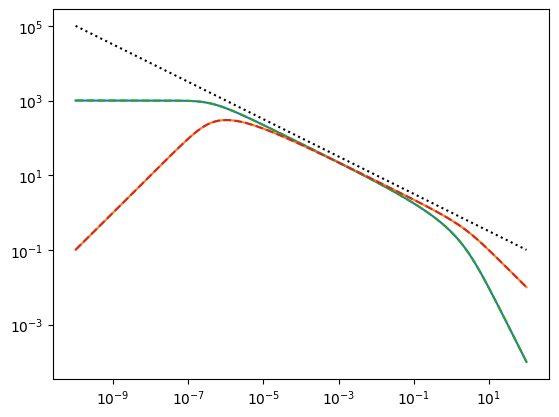

In [32]:
plt.plot(w,f1analytical(-1j*w,1-10**-3).real)
plt.plot(w,f1analytical(-1j*w,1-10**-3).imag)
plt.plot(w,ftcorrelators[4].real, linestyle='dashed')
plt.plot(w,ftcorrelators[4].imag, linestyle='dashed')
plt.plot(w,w**-0.5,color='black',linestyle='dotted')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [33]:
phi_bp = mct.correlator(model=mct.f12model(v1=2.0,v2=0.0,), blocks=50, maxiter=1000000,
                        blocksize=512, accuracy=1e-12, motion_type='newtonian', store=True)

In [34]:
phi_bp.solve_all()

True

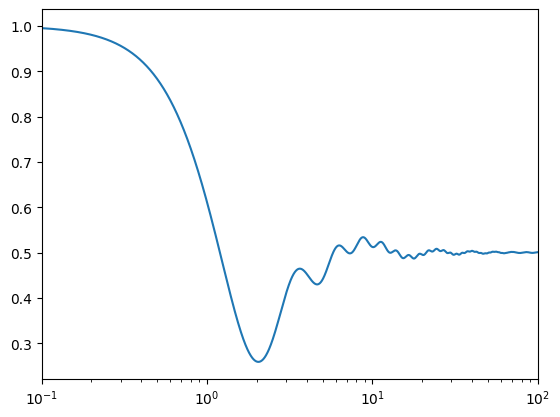

In [35]:
plt.plot(phi_bp.t,phi_bp.phi[:,0])
plt.xscale('log')
plt.xlim(0.1,100)
plt.show()

In [36]:
wlin = np.linspace(1e-5,3.5,200)
phi_bp = FT(phi_bp.phi[:,0]-phi_bp.phi[-1,0], phi_bp.t, wlin)

In [37]:
def f1analytical_nd(s, v1):
    sol1 = (v1-s*s-1)/(2*s*v1) + np.sqrt(((v1-s*s-1)/(2*s*v1))**2+1/(v1))
    sol2 = (v1-s*s-1)/(2*s*v1) - np.sqrt(((v1-s*s-1)/(2*s*v1))**2+1/(v1))
    res = np.zeros_like(sol1)
    z1 = np.sqrt(1-2*np.sqrt(v1)+v1)
    z2 = np.sqrt(1+2*np.sqrt(v1)+v1)
    mask = 1j*s > z2
    res[mask] = sol2[mask]
    res[~mask] = sol1[~mask]
    return res

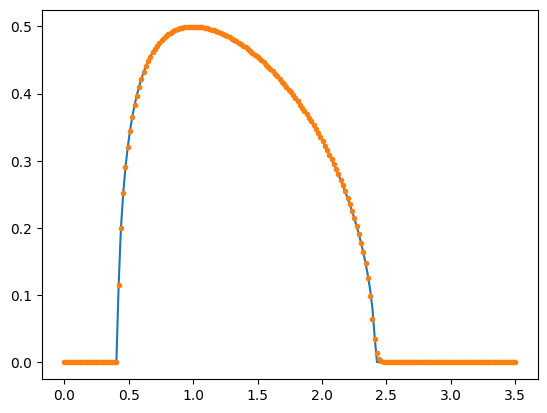

In [38]:
plt.plot(wlin, (f1analytical_nd(-1j*wlin,2.0) - 0.5/(-1j*wlin)).real)
plt.plot(wlin, phi_bp.real, '.')
plt.show()

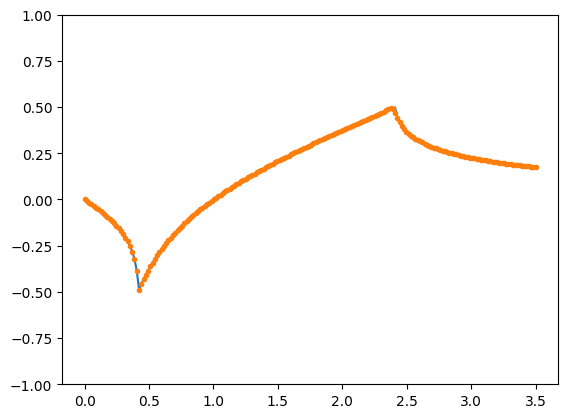

In [39]:
plt.plot(wlin, (f1analytical_nd(-1j*wlin,2.0) - 0.5/(-1j*wlin)).imag)
plt.plot(wlin, phi_bp.imag, '.')
plt.ylim(-1,1)
plt.show()